In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import urllib.request
import requests
import json
import os
import sys
import io
import choroplethNYC as cp
from shapely.geometry import Point
from fiona.crs import from_epsg

from censusAPI import myAPI

%matplotlib inline

# PUMA

## 1.1 dowloading PUMA file and load it 

In [2]:
os.getenv('PUIDATA')

'/home/cusp/vmr286/PUIdata'

In [3]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

urllib.request.urlretrieve(url, os.getenv('PUIDATA') + '/PUMA.gz')

('/home/cusp/vmr286/PUIdata/PUMA.gz',
 <http.client.HTTPMessage at 0x7f999667c588>)

In [6]:
# read the shape file from the unpacked download

#shp_dir = os.getenv('PUIDATA') + '/puma/geo_export_8f093ac6-d035-41c4-a721-a1985c5543f4.shp'
filename = os.getenv('PUIDATA') + '/PUMA'
pumashp = gpd.GeoDataFrame.from_file(filename)

In [7]:
# check the geodataframe 

pumashp.head()

,shape_area,shape_leng,puma,geometry
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...


In [8]:
# check the crs 

pumashp.crs

{'init': 'epsg:4326'}

## 1.2 plotting PUMA file

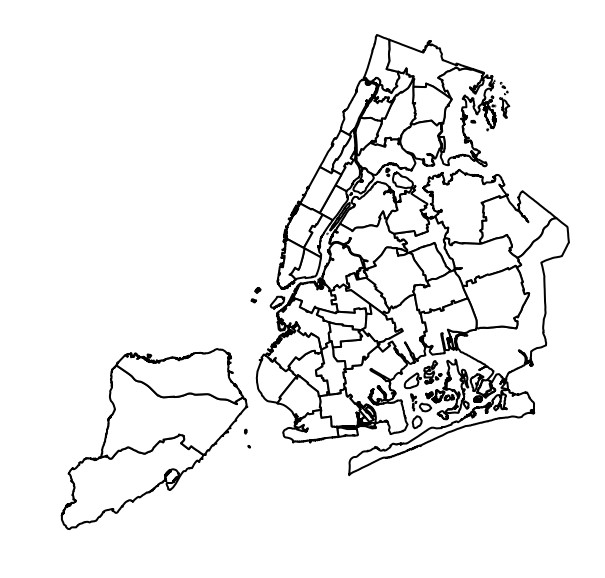

In [9]:
# using Professor Bianco's choropleth file for plotting

cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

Fig 1. the contour map of the New York City with the five boroughs. 

In [10]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [11]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [12]:
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [13]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [14]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [15]:
# getting the broadband access number of households

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [16]:
#getting the first row of the table: the total number of households


url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
# calculate the percent of the population with any type of boardband

pumaBB['pcBB'] = pumaBB['B28002_004E'].astype(float) / pumaPP['B28002_001E'].astype(float) * 100.

In [18]:
pumaBB['pcBB']

0      80.552879
1      75.733321
2      79.842678
3      81.433409
4      78.150656
5      76.568998
6      81.372395
7      84.448726
8      67.002398
9      83.998083
10     81.246002
11     79.407956
12     81.321293
13     86.931662
14     77.812999
15     72.421531
16     83.504962
17     88.494775
18     87.560910
19     77.991104
20     75.950128
21     78.182991
22     84.808653
23     86.725928
24     84.556431
25     79.627474
26     67.200178
27     78.724251
28     85.810689
29     80.374350
         ...    
115    75.874717
116    85.520467
117    89.372770
118    80.639229
119    70.715611
120    76.956665
121    87.658021
122    78.441330
123    74.810319
124    77.017994
125    87.528490
126    66.092036
127    78.778618
128    85.189311
129    83.529541
130    79.301693
131    83.507211
132    78.950159
133    73.297700
134    86.872366
135    86.469011
136    84.739493
137    78.323821
138    85.463855
139    85.065886
140    82.579178
141    83.841021
142    76.7877

In [19]:
# upload the data downloaded from the website

bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

OSError: File b'/home/cusp/vmr286/PUIdata/ACS_16_1YR_GCT2801/ACS_16_1YR_GCT2801.ST50_with_ann.csv' does not exist

### Grader comment: This has to be reproducible.

In [26]:
# adjust the top row to be the header 

new_header = bbpc.iloc[0] 
bbpc = bbpc[1:] 
bbpc.columns = new_header 

bbpc.head()

NameError: name 'bbpc' is not defined

In [21]:
bbpc.columns

NameError: name 'bbpc' is not defined

In [22]:
bbpc['Target Geo Id2'] = bbpc['Target Geo Id2'].apply(pd.to_numeric, errors='coerce')

NameError: name 'bbpc' is not defined

In [23]:
bbpc.head()

NameError: name 'bbpc' is not defined

In [24]:
bbpc['gid'] = bbpc['Target Geo Id2'] - 3600000

bbpc['gid']

NameError: name 'bbpc' is not defined

In [25]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "Percent"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["Percent"].astype(float))

diff_.describe()

NameError: name 'bbpc' is not defined

## 3. plot the choropleth of percentage with internet access

In [27]:
# merge the percentage of broadband access with puma shapefile based on puma id

pumashp.puma = pd.to_numeric(pumashp.puma, errors='raise')

pumashp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area', how='left')

pumashp.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,pcBB
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84.275820
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,68.310015
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,82.826141
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,72.553737
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,69.425612


In [28]:
pumashp.pcBB.describe()

count    55.000000
mean     79.462797
std       7.548276
min      54.932945
25%      74.772059
50%      79.301693
75%      85.127599
max      93.030650
Name: pcBB, dtype: float64

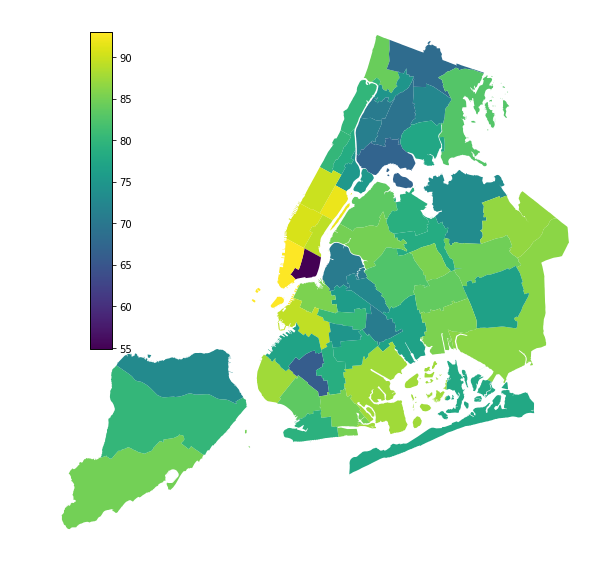

In [29]:
#choropleth of the percentage of internet axcess
# pumashp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area', how='left')

f, ax, cb = cp.choroplethNYC(pumashp, "pcBB", kind='continuous', cmap="viridis")

Fig. 2 Notice the highest broadband access rate is lower mahattan with the rate declined drastically in Bronx and some region in Brooklyn and Queens. Also the lower east side shows extremely low in broadband access which is the low of 54.

## 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [30]:
# downloading the dataset from github and clean the dataset

linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv')

In [31]:
linkNYC.columns

Index(['Unnamed: 0', 'link_site', 'longitude', 'date_link_', 'latitude'], dtype='object')

In [32]:
linkNYC.drop(['Unnamed: 0'], axis=1, inplace=True)

linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [33]:
linkNYC.shape

(1414, 4)

In [34]:
# creating the geometry for the lat lon information and each station is creates as a point

linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))

linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [35]:
linkNYC['geometry'] = linkNYC.lonlat.apply(lambda x: Point(x))

linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [36]:
linkNYC = gpd.GeoDataFrame(linkNYC)
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [47]:
#linkNYC.crs
linkNYC.crs = from_epsg(4326)

### plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

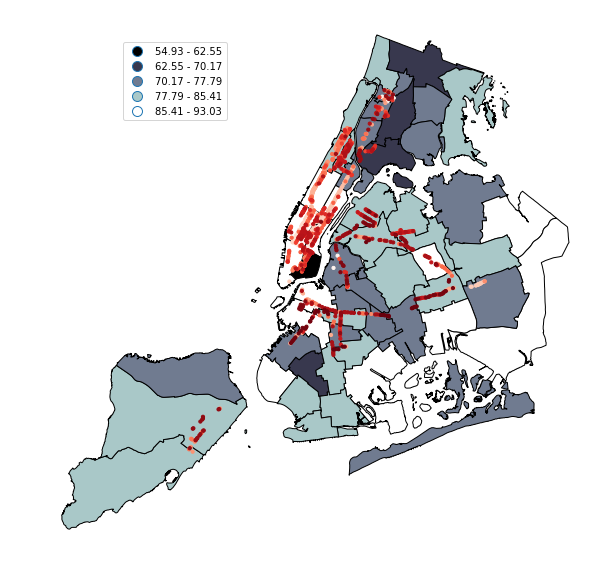

In [38]:
f, ax, cb = cp.choroplethNYC(pumashp, "pcBB", scheme='Equal_Interval',k=5, cmap="bone",edgecolor='black')

linkNYC.plot(c=linkNYC.date_link_, ax=ax, cmap='Reds', markersize=10)

Fig 3. Locations of the linkNYC stations on top of choropleth for percentage of broadband access for the population. It shows many stations concentrated in the lower mahattan area which is also the area with the highest broadband access rate. There are some stations in queens and west side of Bronx do appear in the region with lower rate of broadband access but there is almost no station in region of some of the lowest rate for broadband access. 

### 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [39]:
# getting the population per PUMA

keyNPOP = 'B00001_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [40]:
pumaPop['public use microdata area'] = pd.to_numeric(pumaPop['public use microdata area'], errors='raise')

### 5.2 find the number of station per 100 people per PUMA

In [41]:
pumashp.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,pcBB
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84.275820
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,68.310015
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,82.826141
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,72.553737
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,69.425612


In [42]:
pumashp.puma = pd.to_numeric(pumashp.puma, errors='raise')

In [43]:
# to merge the shape file and population data for each puma

pumashp_ = pumashp.merge(pumaPop, left_on='puma', right_on='public use microdata area')

pumashp_.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,Unnamed: 4_x,pcBB,B00001_001E,NAME_y,state_y,public use microdata area_y,Unnamed: 4_y
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,69.425612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN


In [44]:
# per 100 people so the population should be devided by 100

aff1y['variables']['B00001_001E']

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [48]:
# converting coordinate and perform spatial joint

pumashp_ft = pumashp_.to_crs(epsg=2263)

linkNYC_ft = linkNYC.to_crs(epsg=2263)

linkpp = gpd.sjoin(pumashp_ft,linkNYC_ft,how='inner')

linkpp.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,Unnamed: 4_x,pcBB,...,NAME_y,state_y,public use microdata area_y,Unnamed: 4_y,index_right,link_site,longitude,date_link_,latitude,lonlat
0,9.792852e+07,53227.144357,3701,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84.275820,...,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,1286,bx-08-145850,-73.902101,2017-06-10,40.868698,"(-73.9021009, 40.86869849)"
4,1.224950e+08,68630.512052,3705,"POLYGON ((1015377.269592287 238959.501403747, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,69.425612,...,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,927,bx-06-118922,-73.898221,2017-10-20,40.846926,"(-73.898220556, 40.8469261747)"
5,4.388687e+07,51799.404760,3706,"POLYGON ((1018060.325195312 261167.655395456, ...",34391,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,74.733800,...,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,917,bx-05-119659,-73.893343,2016-12-06,40.860027,"(-73.893343, 40.860027)"
5,4.388687e+07,51799.404760,3706,"POLYGON ((1018060.325195312 261167.655395456, ...",34391,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,74.733800,...,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,25,bx-05-116218,-73.893059,2016-05-12,40.860215,"(-73.89305944, 40.86021467)"
5,4.388687e+07,51799.404760,3706,"POLYGON ((1018060.325195312 261167.655395456, ...",34391,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,74.733800,...,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,1283,bx-05-145959,-73.897400,2017-10-06,40.861150,"(-73.8974, 40.86115)"


In [49]:
pumashplc = pumashp_.merge(linkpp.groupby('puma')[['link_site']].count().reset_index(), on='puma',how='left')

pumashplc.head()

,shape_area,shape_leng,puma,geometry,B28002_004E,NAME_x,state_x,public use microdata area_x,Unnamed: 4_x,pcBB,B00001_001E,NAME_y,state_y,public use microdata area_y,Unnamed: 4_y,link_site
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84.275820,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,1.0
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,68.310015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,NaN
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,82.826141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,NaN
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,72.553737,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,NaN
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,69.425612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,1.0


In [50]:
# get the link site per hundred people. But this calulation excludes the puma without any link sites

pumashplc["linkNYCp100p"] = pumashplc['link_site'] / (pumashplc[keyNPOP]  / 100)

pumashplc["linkNYCp100p"].describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

In [51]:
# this accounts for the puma with zero link sites which gives a lower mean

pumashplc["linkNYCp100p"] = pumashplc['link_site'].fillna(value=0) / (pumashplc[keyNPOP]  / 100)

pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

In [52]:
pumashplc = pumashplc.merge(linkpp, on='puma',how='left')

AttributeError: Unknown property k

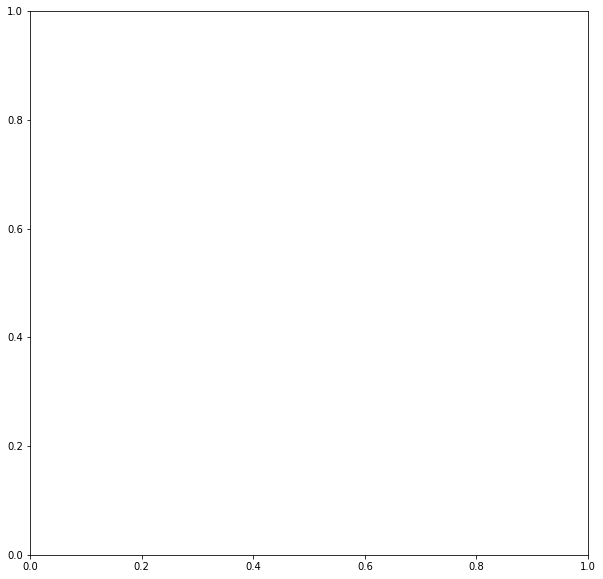

In [56]:
f, ax, cb = cp.choroplethNYC(pumashplc, "linkNYCp100p", scheme='Equal_Interval',k=10, cmap="bone",edgecolor='black')

linkNYC.plot(c=linkNYC.date_link_, ax=ax, cmap='Reds', markersize=10)

Fig 4. The map with link stations per hundred people in the PUMA with stations locations overlay on the map. Most the regions have low link stations per 100 people as indicated by the dark regions on the map. The light region light up is again where many those link stations concentrated and it will not help with the situations of low internet access.  

### Grade: 8/10